In [2]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

# Funções

In [33]:
def FetchSyntheticInput(instance, data, distance_option):
    df = pd.read_csv(f'sinteticos/{data}/data_{instance}.csv')
    for column in df.columns[:2]:
        if column != 'label':
            df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

    x = []
    y = []
    labels = []
    for curr_x, curr_y, label in df[['x', 'y', 'label']].values:
        x.append(curr_x)
        y.append(curr_y)
        labels.append(label)
    points = np.vstack((x, y)).T
    distances = np.linalg.norm(points[:, np.newaxis, :] - points[np.newaxis, :, :], ord=distance_option, axis=-1)
    
    return points.tolist(), distances.tolist(), labels

In [34]:
def KmeansRefined(points, distances, difference, k):
    rmax = max([max(i) for i in distances])
    #print('rmax:', rmax)
    original_rmax = rmax
    rmin = 0
    curr_r = 0
    centers = []
    while True:
        curr_r = (rmin + rmax) / 2
        centers = []

        copy_points = [i for i in range(len(points))]
        while copy_points != []:
            i = random.choice(copy_points)
            centers.append(points[i])
            copy_points.remove(i)
            aux = [i for i in copy_points]
            for j in aux:
                distance = distances[i][j]
                if distance <= 2 * curr_r:
                    copy_points.remove(j)

        if (rmax - rmin)/original_rmax < difference and len(centers) <= k:
            break

        if len(centers) > k:
            rmin = (rmin + rmax) / 2

        else:
            rmax = (rmin + rmax) / 2
        

    return centers, (rmax + rmin) / 2

# Dados sintéticos

Maior raio: 0.20627524274737707
Tempo de execução: 0.43s


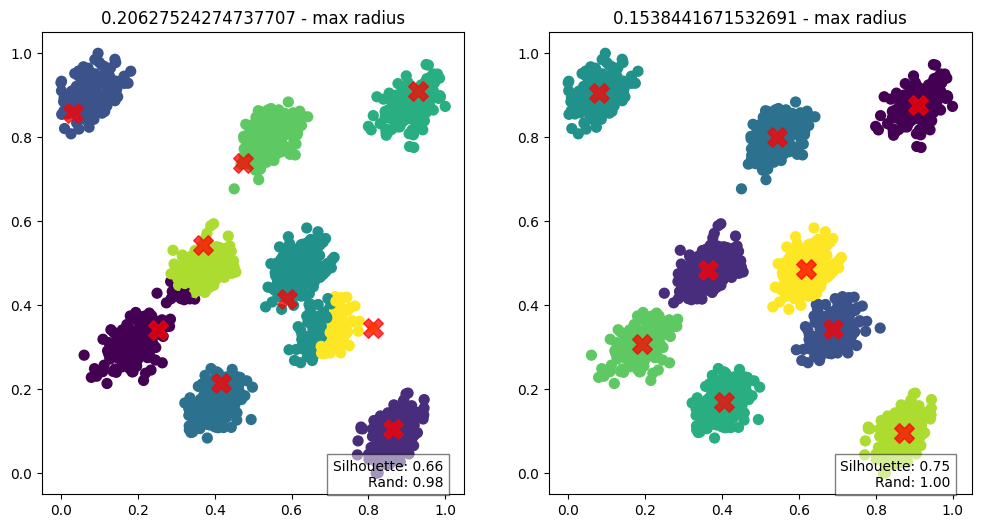

Maior raio: 0.17906039840405155
Tempo de execução: 0.38s


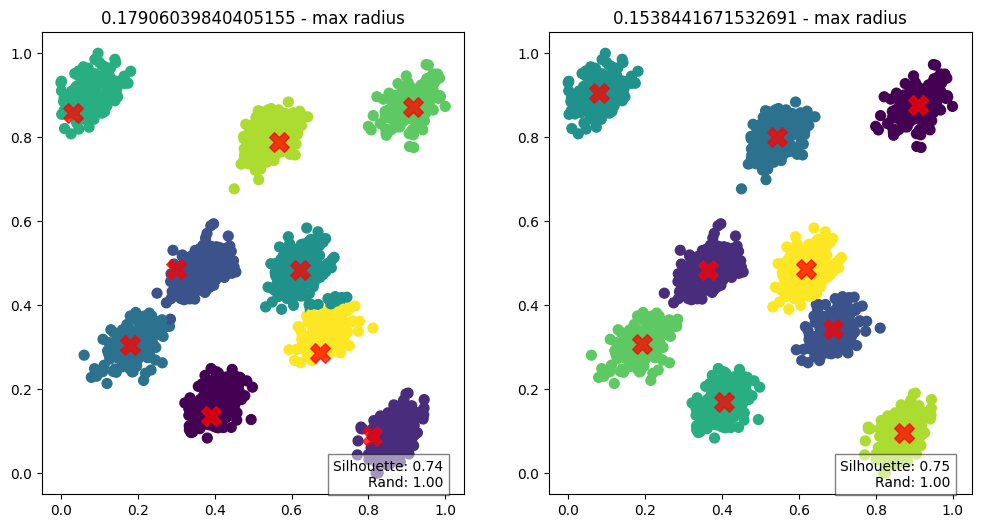

Maior raio: 0.20185307908469866
Tempo de execução: 0.35s


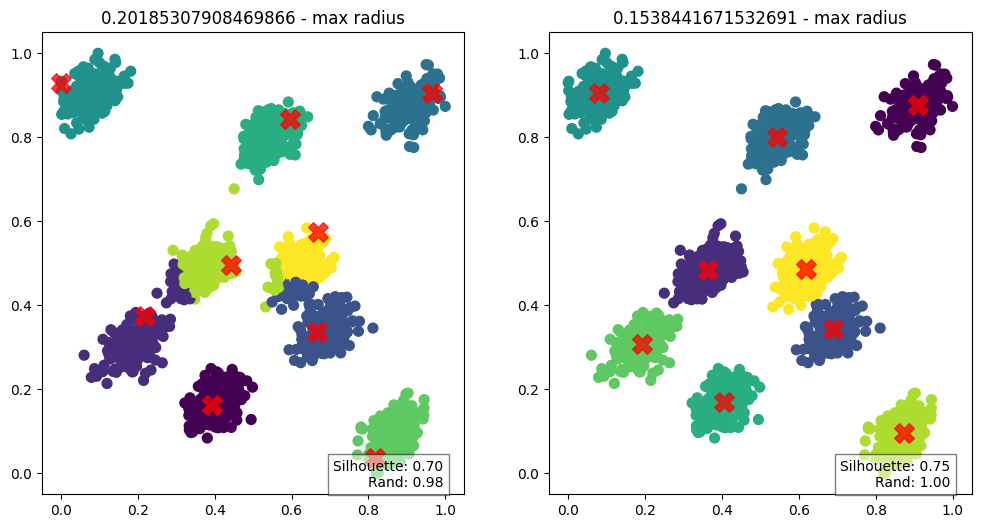

Maior raio: 0.2278406764186038
Tempo de execução: 0.35s


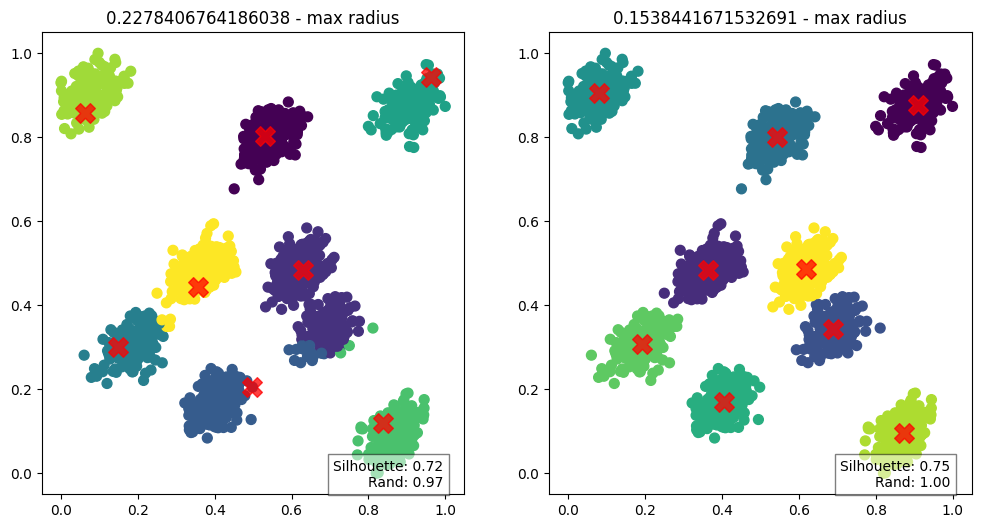

Maior raio: 0.18494470097400975
Tempo de execução: 0.48s


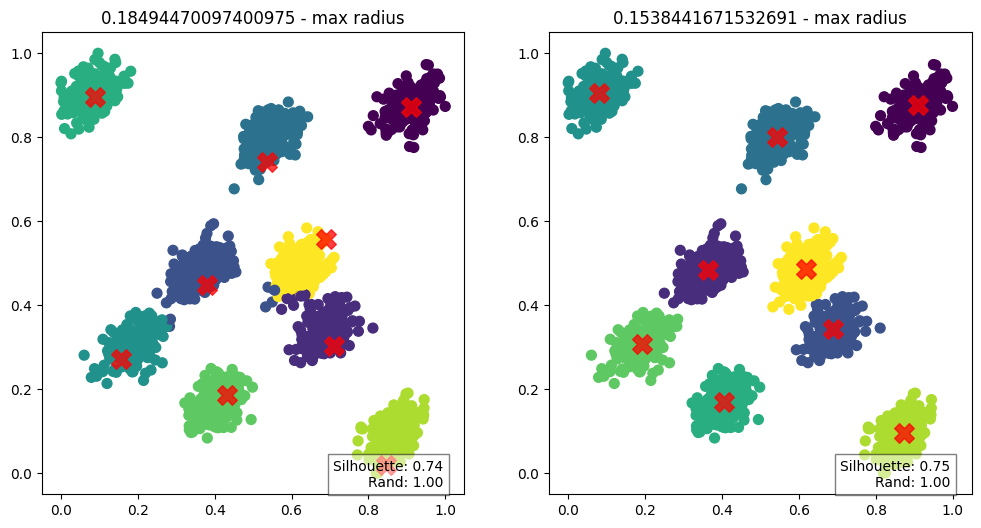

In [35]:
refinamento = [0.01, 0.04, 0.09, 0.16, 0.25]
for r in refinamento:
    inicio = time.time()
    points, distances, input_labels = FetchSyntheticInput(4, 1, 2)
    # print(input_labels)
        
    # Configurar o tamanho da figura
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Parte 1: Algoritmo refinamento_k_means

    k = len([x for i, x in enumerate(input_labels) if x not in input_labels[:i]])

    centers, max_r = KmeansRefined(points, distances, r, k)
    # df = pd.DataFrame(columns=['x', 'y', 'label'])

    labels = []
    d = []
    for point in points:
        current_distance = 0
        nearest_center = 0
        for center in centers:
            if point == center:
                current_distance = 0
                nearest_center = center
                break
            distance = ((point[0] - center[0])**2 + (point[1] - center[1])**2)**0.5
            if distance < current_distance or (current_distance == 0):
                current_distance = distance
                nearest_center = center
        d.append(current_distance) 
            
        labels.append(centers.index(nearest_center))
    max_r = max(d)
    print('Maior raio:',max_r)
    ss = silhouette_score(np.array(points), labels)
    rs = rand_score(input_labels, labels)

    # Plotar o resultado do greedy_k_means
    ax[0].scatter([p[0] for p in points], [p[1] for p in points], c=labels, s=50, cmap='viridis')
    ax[0].scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=200, alpha=0.75, marker='X')
    ax[0].set_title(f'{max_r} - max radius')
    ax[1].text(0.95, 0.01, f'Silhouette: {ss:.2f}\nRand: {rs:.2f}',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax[0].transAxes, color='black', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.5))


    # Parte 2: K-means do sklearn
    X, y = np.array(points), input_labels
    kmeans = KMeans(n_clusters=len([x for i, x in enumerate(y) if x not in y[:i]]), random_state=42)
    labels = kmeans.fit_predict(X)
    distance = lambda x1, x2: ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)**0.5
    max_r_sklearn = max([distance(j,kmeans.cluster_centers_[labels[i]]) for i,j in enumerate(X)])

    # Imprimir métricas
    sil_score = silhouette_score(np.array(points), labels)
    rand_score_value = rand_score(y, labels)

    # Plotar o resultado do K-means
    # ax[1].scatter(X.values[:, 0], X.values[:, 1], c=y, s=50, cmap='viridis')
    ax[1].scatter([p[0] for p in points], [p[1] for p in points], c=labels, s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
    ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
    ax[1].text(0.95, 0.01, f'Silhouette: {sil_score:.2f}\nRand: {rand_score_value:.2f}',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax[1].transAxes, color='black', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.5))
    # Configurar título e rótulos
    ax[1].set_title(f'{max_r_sklearn} - max radius')
    print(f'Tempo de execução: {time.time() - inicio:.2f}s')

    # Exibir os gráficos
    plt.show()

In [ ]:
type = 1
data = 2
metrics = []
csv_files = [f'data_{i}.csv' for i in range(10)]
refinamento = 0.25
for i, csv in enumerate(tqdm(csv_files)):

    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    points, distances, input_labels = FetchSyntheticInput(i, data, type)
    # print(input_labels)
    # print(points)
    k = len([x for i, x in enumerate(input_labels) if x not in input_labels[:i]])
    for j in range(30):
        start = time.time()
        centers, max_r = KmeansRefined(points, distances, refinamento, k)
        end = time.time()
        #print('Tempo de execução:', end - start)
        labels = []
        r_v = []
        max_distance = 0

        for point in points:
            current_distance = 0
            nearest_center = 0
            for center in centers:
                if point == center:
                    current_distance = 0
                    nearest_center = center
                    break
                point1 = np.array([point[0], point[1]])
                center1 = np.array([center[0], center[1]])
                distance = np.linalg.norm(point1 - center1,type)
                if distance < current_distance or (current_distance == 0):
                    current_distance = distance
                    nearest_center = center
            r_v.append(current_distance) 

            labels.append(centers.index(nearest_center))
        
        # print(labels)
        radius.append(max(r_v))
        times.append(end - start)
        sillhouette_s.append(silhouette_score(np.array(points), labels))
        rand_s.append(rand_score(input_labels, labels))
    print('Instância:', i, ' Finalizada')
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])

df_greedy = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_rand_s'])

In [37]:
type = 1

p = '004'
df_greedy = pd.read_csv(f'reais/1/greedy_kmeans_{p}_{type}.csv')
for i in range(4):
    df_greedy += pd.read_csv(f'reais/{i + 1}/greedy_kmeans_{p}_{type}.csv')

df_greedy /= 5
df_greedy

,mean_radius,std_radius,mean_time,mean_sillhouette_s,std_sillhouette_s,mean_rand_s,std_r and_s
0,1.621189,0.056368,0.581165,0.206969,0.041369,0.602771,0.038288


# Dados reais 

In [6]:
def FetchRealInput(df, distance_option, columns, target):
    for column in columns:
        if column != target:
            df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    labels = []
    for label in df[[target]].values:
        labels.append(label[0])
    points = np.vstack(df.loc[:, df.columns != target].values)
    # print(set(labels))
    distances = np.linalg.norm(points[:, np.newaxis, :] - points[np.newaxis, :, :], ord=distance_option, axis=-1)
    # print(distances.shape)
    return points.tolist(), distances.tolist(), labels

## 1 e 4 - Vinhos

In [19]:
df = pd.read_csv('reais/1/winequality-red.csv', sep = ';')
columns = ['alcohol', 'density', 'volatile acidity', 'free sulfur dioxide','total sulfur dioxide', 'residual sugar']
df = df[columns + ['quality']]
# points, distances, input_labels = FetchRealInput(df, 2, columns)

In [21]:
type = 2
data = 1
metrics = []
# csv_files = [f'data_{i}.csv' for i in range(10)]
refinamentos = [0.01, 0.04, 0.09, 0.16, 0.25]
for refinamento in refinamentos:
    radius = []
    times = []
    sillhouette_s = []
    rand_s = []
    points, distances, input_labels = FetchRealInput(df, type, columns, 'quality')
    # print(input_labels)
    # print(points)
    k = len([x for i, x in enumerate(input_labels) if x not in input_labels[:i]])
    for j in range(30):
        start = time.time()
        centers, max_r = KmeansRefined(points, distances, refinamento, k)
        end = time.time()
        #print('Tempo de execução:', end - start)
        labels = []
        r_v = []
        max_distance = 0

        for point in points:
            current_distance = 0
            nearest_center = 0
            for center in centers:
                if point == center:
                    current_distance = 0
                    nearest_center = center
                    break
                distance = np.linalg.norm(np.array(point) - np.array(center), type)
                if distance < current_distance or (current_distance == 0):
                    current_distance = distance
                    nearest_center = center
            r_v.append(current_distance) 

            labels.append(centers.index(nearest_center))
        
        # print(labels)
        radius.append(max(r_v))
        times.append(end - start)
        sillhouette_s.append(silhouette_score(np.array(points), labels))
        rand_s.append(rand_score(input_labels, labels))
    print('Instância:', refinamento, ' Finalizada')
    mean_radius = np.mean(radius)
    mean_time = np.mean(times)
    mean_sillhouette_s = np.mean(sillhouette_s)
    mean_rand_s = np.mean(rand_s)
    
    std_radius = np.std(radius)
    std_sillhouette_s = np.std(sillhouette_s)
    std_rand_s = np.std(rand_s)
    
    metrics.append([mean_radius, std_radius, mean_time, mean_sillhouette_s, std_sillhouette_s, mean_rand_s, std_rand_s])
    df_greedy = pd.DataFrame(metrics, columns=['mean_radius', 'std_radius', 'mean_time', 'mean_sillhouette_s', 'std_sillhouette_s', 'mean_rand_s', 'std_r and_s'])
    refinamento = str(refinamento).replace('.','')
    df_greedy.to_csv(f'reais/{data}/greedy_kmeans_{refinamento}_{type}.csv', index=False)

Instância: 0.01  Finalizada
Instância: 0.04  Finalizada
Instância: 0.09  Finalizada
Instância: 0.16  Finalizada
Instância: 0.25  Finalizada
